**Imports + small helper functions**

In [ ]:
import os, re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Read train/test/sample whether they are .xlsx or .csv
def load_any(path_wo_ext):
    for ext, reader in [(".xlsx", pd.read_excel), (".csv", pd.read_csv)]:
        fn = path_wo_ext + ext
        if os.path.exists(fn):
            return reader(fn)
    raise FileNotFoundError(f"Missing {path_wo_ext}.xlsx or {path_wo_ext}.csv")

# Try to pick good columns automatically
TEXT_CANDS  = ["description","overview","plot","story","synopsis","text","movie_description","review"]
LABEL_CANDS = ["genre","genres","label","category","target"]

def pick_column(df, candidates):
    lower = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c in lower: return lower[c]
    # fallback: longest text-like column
    textish = [c for c in df.columns if df[c].dtype == "object"]
    return max(textish, key=lambda c: df[c].astype(str).str.len().mean()) if textish else df.columns[0]

def is_multilabel_series(s):
    if s.dtype != "object": return False
    return s.dropna().astype(str).str.contains(r"[|,;/]").any()

def split_labels(cell):
    if pd.isna(cell): return []
    return [p.strip() for p in re.split(r"[|,;/]", str(cell)) if p.strip()]


**Upload files in Colab**

In [ ]:
from google.colab import files
import pandas as pd

# Upload multiple files at once (choose train.csv, test.csv, sample_submission.csv)
uploaded = files.upload()

# Load the CSVs
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

# Show dataset info
print("Train:", train.shape)
print("Test :", test.shape)
print("Sample:", sample.shape)

# Quick preview
train.head()


Saving sample_submission.csv to sample_submission (5).csv
Saving test.csv to test (5).csv
Saving train.csv to train (6).csv
Train: (54000, 4)
Test : (36000, 4)
Sample: (36000, 2)


,id,movie_name,synopsis,genre
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy
1,50185,Entity Project,A director and her friends renting a haunted h...,horror
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action


**Inspect the dataset**

In [ ]:
# Look at first few rows
print("Train data:")
print(train.head())

print("\nTest data:")
print(test.head())

print("\nSample submission:")
print(sample.head())

# Check column names
print("\nTrain columns:", list(train.columns))
print("Test columns :", list(test.columns))
print("Sample columns:", list(sample.columns))


Train data:
      id                                         movie_name  \
0  44978                                           Super Me   
1  50185                                     Entity Project   
2  34131  Behavioral Family Therapy for Serious Psychiat...   
3  78522                                      Blood Glacier   
4   2206                                      Apat na anino   

                                            synopsis    genre  
0  A young scriptwriter starts bringing valuable ...  fantasy  
1  A director and her friends renting a haunted h...   horror  
2  This is an educational video for families and ...   family  
3  Scientists working in the Austrian Alps discov...    scifi  
4  Buy Day - Four Men Widely - Apart in Life - By...   action  

Test data:
      id          movie_name  \
0  16863    A Death Sentence   
1  48456          Intermedio   
2  41383    30 Chua Phai Tet   
3  84007           Paranoiac   
4  40269  Ordinary Happiness   

                    

**Check the columns first**

In [ ]:
print(train.columns)


Index(['id', 'movie_name', 'synopsis', 'genre'], dtype='object')


**Corrected Preprocessing**

In [ ]:
import re
from sklearn.model_selection import train_test_split

# Use synopsis as input (X) and genre as target (y)
X = train["synopsis"]
y = train["genre"]

# Simple text cleaning function
def clean_text(text):
    text = str(text).lower()                       # lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)     # remove punctuation
    return text

X = X.apply(clean_text)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))


Training samples: 43200
Validation samples: 10800


**Text Vectorization + Model Training**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Convert text (synopsis) into numeric vectors
vectorizer = TfidfVectorizer(max_features=5000)   # limit to top 5000 words
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_val_tfidf)

# Evaluate
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Validation Accuracy: 0.3548148148148148

Classification Report:
               precision    recall  f1-score   support

      action       0.29      0.25      0.27      1094
   adventure       0.30      0.23      0.26      1067
       crime       0.36      0.39      0.37      1134
      family       0.38      0.43      0.41      1049
     fantasy       0.32      0.30      0.31      1057
      horror       0.39      0.46      0.43      1116
     mystery       0.30      0.28      0.29      1074
     romance       0.46      0.61      0.52      1075
       scifi       0.39      0.44      0.41      1077
    thriller       0.24      0.15      0.19      1057

    accuracy                           0.35     10800
   macro avg       0.34      0.35      0.34     10800
weighted avg       0.34      0.35      0.35     10800



**Predict on Test Data & Create Submission File**

In [ ]:
# Clean test synopsis just like train
X_test = test["synopsis"].apply(clean_text)

# Transform using the same vectorizer
X_test_tfidf = vectorizer.transform(X_test)

# Predict genres
test_preds = model.predict(X_test_tfidf)

# Create submission DataFrame
submission = sample.copy()
submission["genre"] = test_preds

# Save submission file
submission.to_csv("submission.csv", index=False)

print("✅ Submission file created: submission.csv")
submission.head()


✅ Submission file created: submission.csv


,id,genre
0,57609,family
1,30111,horror
2,36119,fantasy
3,65901,horror
4,41910,scifi


from matplotlib import pyplot as plt
_df_14['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_15.groupby('genre').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['genre'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='id', y='genre', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-3075435391.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(_df_17, x='id', y='genre', inner='stick', palette='Dark2')


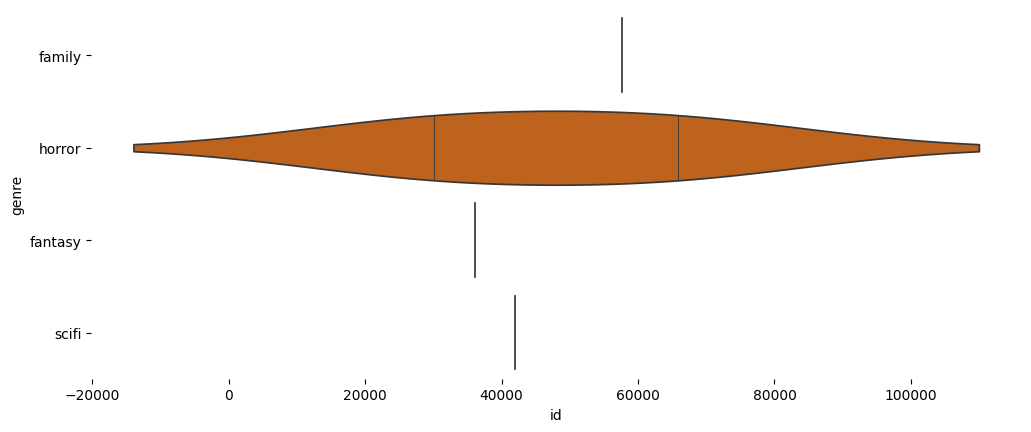

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['genre'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='id', y='genre', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

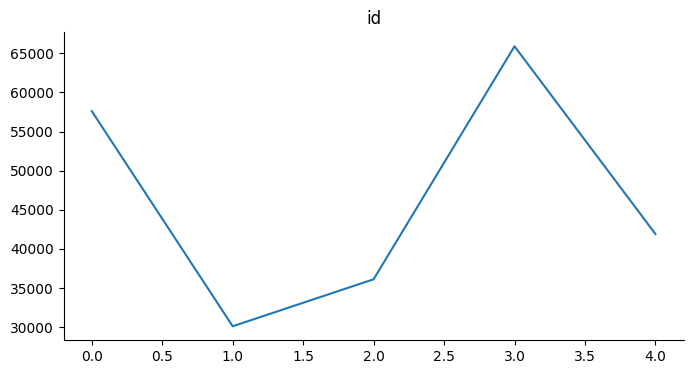

In [ ]:
from matplotlib import pyplot as plt
_df_16['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

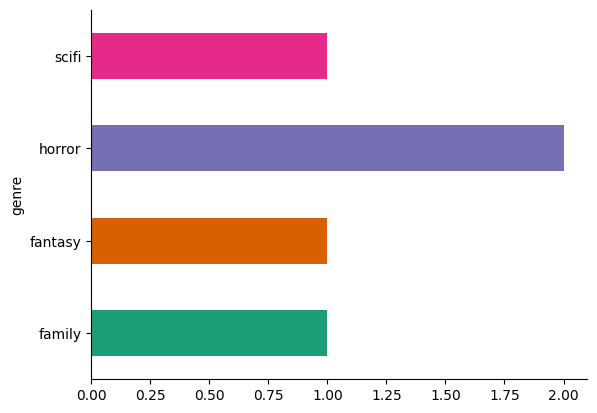

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_15.groupby('genre').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

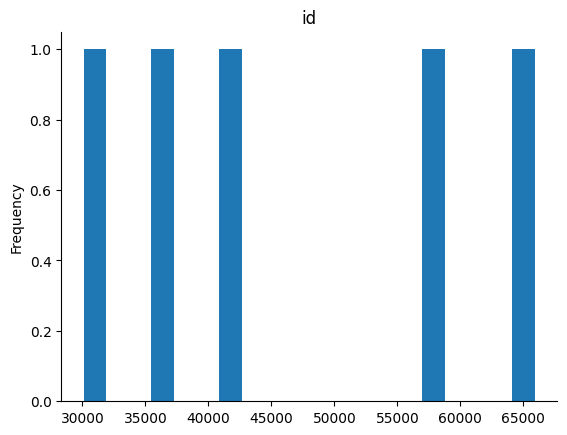

In [ ]:
from matplotlib import pyplot as plt
_df_14['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from google.colab import files

# Download the file to your local computer
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>